XGBoost ROS

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Load preprocessed data
data = pd.read_excel(r'\Users\isabe\OneDrive\Documenten\Master DDS\Thesis\A\Data\Final_data.xlsx')

# Define predictor variables and target variable
X = data[['needle_fear', 'HRV', 'nic_caf', 'prior_donor', 'gender']]
y = data['vasovagal_enc']

# Encode target variable
labels = ['none', 'VVR']
y_encoded = pd.Categorical(y, categories=[0, 1], ordered=True).codes

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Resample the training data using RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.5],
    'gamma': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 1, 10]
}

# Train an XGBoost classifier on the resampled training data using GridSearchCV
xgb_ROS = XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgb_ROS, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)

# Train an XGBoost classifier on the resampled training data with the best hyperparameters found by GridSearchCV
xgb_ROS = XGBClassifier(random_state=42, **grid_search.best_params_)
xgb_ROS.fit(X_train_resampled, y_train_resampled)

# Perform cross-validation to get variance of performance across different folds
cv_scores = cross_val_score(xgb_ROS, X_train_resampled, y_train_resampled, cv=5, scoring='f1')
print("Cross-validation scores:", cv_scores)
print("Variance of cross-validation scores:", np.var(cv_scores))

# Evaluate performance on the test set
y_test_pred = xgb_ROS.predict(X_test)
print("Test set performance:")
print(classification_report(y_test, y_test_pred, target_names=labels))


conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix Test:")
print(conf_matrix)




Best hyperparameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 0.1}
Cross-validation scores: [0.93333333 0.85714286 1.         0.93333333 1.        ]
Variance of cross-validation scores: 0.002808163265306124
Test set performance:
              precision    recall  f1-score   support

        none       1.00      0.89      0.94         9
         VVR       0.75      1.00      0.86         3

    accuracy                           0.92        12
   macro avg       0.88      0.94      0.90        12
weighted avg       0.94      0.92      0.92        12

Confusion matrix Test:
[[8 1]
 [0 3]]


In [74]:
# Evaluate performance on the training set
y_train_pred = xgb_ROS.predict(X_train_resampled)
y_train_pred_prob = xgb_ROS.predict_proba(X_train_resampled)[:, 1]
auc_train = roc_auc_score(y_train_resampled, y_train_pred_prob)

print("Training set performance:")
print(classification_report(y_train_resampled, y_train_pred, target_names=labels))
print("AUC Train:", auc_train)

Training set performance:
              precision    recall  f1-score   support

        none       0.97      0.97      0.97        34
         VVR       0.97      0.97      0.97        34

    accuracy                           0.97        68
   macro avg       0.97      0.97      0.97        68
weighted avg       0.97      0.97      0.97        68

AUC Train: 0.9974048442906575


XGBoost ROS ROC

ROC AUC score:
0.92


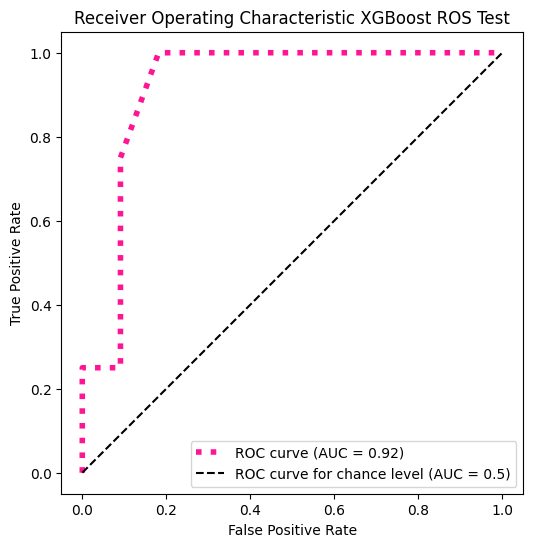

In [52]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
from sklearn.preprocessing import label_binarize
import numpy as np


y_pred_prob = xgb_ROS.predict_proba(X_test)[:, 1]  # Use the probabilities for the positive class
n_classes = 2
target_names = ['none', 'VVR']

# Compute ROC curve and ROC area for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC score:\n{roc_auc:.2f}")

# Plot ROC curve
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(
    fpr,
    tpr,
    label=f"ROC curve (AUC = {roc_auc:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

# Plot the diagonal line representing chance level
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic XGBoost ROS Test")
plt.legend()
plt.show()


XGBoost SMOTE

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Load preprocessed data
data = pd.read_excel(r'\Users\isabe\OneDrive\Documenten\Master DDS\Thesis\A\Data\Final_data.xlsx')

# Define predictor variables and target variable
X = data[['needle_fear', 'HRV', 'nic_caf', 'prior_donor', 'gender']]
y = data['vasovagal_enc']

# Encode target variable
labels = ['none', 'VVR']
y_encoded = pd.Categorical(y, categories=[0, 1], ordered=True).codes

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Resample the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.5],
    'gamma': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 1, 10]
}

# Train an XGBoost classifier on the resampled training data using GridSearchCV
xgb_SMOTE = XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgb_SMOTE, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)

# Train an XGBoost classifier on the resampled training data with the best hyperparameters found by GridSearchCV
xgb_SMOTE = XGBClassifier(random_state=42, **grid_search.best_params_)
xgb_SMOTE.fit(X_train_resampled, y_train_resampled)

# Perform cross-validation to get variance of performance across different folds
cv_scores = cross_val_score(xgb_SMOTE, X_train_resampled, y_train_resampled, cv=5, scoring='f1')
print("Cross-validation scores:", cv_scores)
print("Variance of cross-validation scores:", np.var(cv_scores))

# Evaluate performance on the test set
y_test_pred = xgb_SMOTE.predict(X_test)
print("Test set performance:")
print(classification_report(y_test, y_test_pred, target_names=labels))

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix Test:")
print(conf_matrix)




Best hyperparameters: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_lambda': 0.1}
Cross-validation scores: [0.93333333 0.83333333 1.         0.93333333 0.90909091]
Variance of cross-validation scores: 0.0028738292011019307
Test set performance:
              precision    recall  f1-score   support

        none       1.00      0.89      0.94         9
         VVR       0.75      1.00      0.86         3

    accuracy                           0.92        12
   macro avg       0.88      0.94      0.90        12
weighted avg       0.94      0.92      0.92        12

Confusion matrix Test:
[[8 1]
 [0 3]]


In [76]:
# Evaluate performance on the training set
y_train_pred = xgb_SMOTE.predict(X_train_resampled)
y_train_pred_prob = xgb_SMOTE.predict_proba(X_train_resampled)[:, 1]
auc_train = roc_auc_score(y_train_resampled, y_train_pred_prob)

print("Training set performance:")
print(classification_report(y_train_resampled, y_train_pred, target_names=labels))
print("AUC Train:", auc_train)

Training set performance:
              precision    recall  f1-score   support

        none       0.97      0.94      0.96        34
         VVR       0.94      0.97      0.96        34

    accuracy                           0.96        68
   macro avg       0.96      0.96      0.96        68
weighted avg       0.96      0.96      0.96        68

AUC Train: 0.9939446366782007


XGBoost SMOTE ROC

ROC AUC score:
0.91


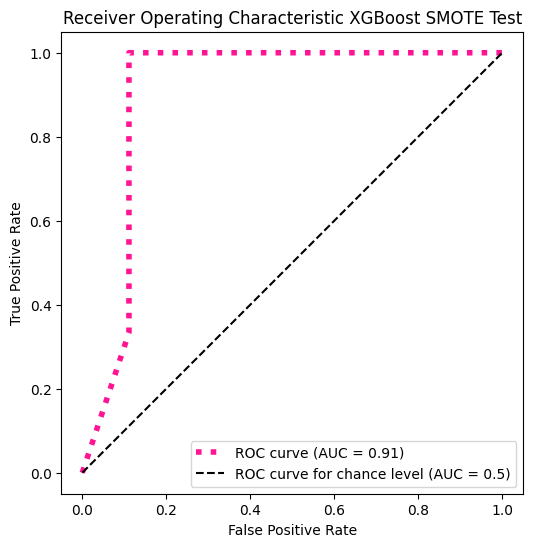

In [27]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
from sklearn.preprocessing import label_binarize
import numpy as np


y_pred_prob = xgb_SMOTE.predict_proba(X_test)[:, 1]  # Use the probabilities for the positive class
n_classes = 2
target_names = ['none', 'VVR']

# Compute ROC curve and ROC area for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC score:\n{roc_auc:.2f}")

# Plot ROC curve
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(
    fpr,
    tpr,
    label=f"ROC curve (AUC = {roc_auc:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

# Plot the diagonal line representing chance level
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic XGBoost SMOTE Test")
plt.legend()
plt.show()


XGBoost ADASYN

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Load preprocessed data
data = pd.read_excel(r'\Users\isabe\OneDrive\Documenten\Master DDS\Thesis\A\Data\Final_data.xlsx')

# Define predictor variables and target variable
X = data[['needle_fear', 'HRV', 'nic_caf', 'prior_donor', 'gender']]
y = data['vasovagal_enc']

# Encode target variable
labels = ['none', 'VVR']
y_encoded = pd.Categorical(y, categories=[0, 1], ordered=True).codes

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Resample the training data using ADASYN
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.5],
    'gamma': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 1, 10]
}

# Train an XGBoost classifier on the resampled training data using GridSearchCV
xgb_adasyn = XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgb_adasyn, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)

# Train an XGBoost classifier on the resampled training data with the best hyperparameters found by GridSearchCV
xgb_adasyn = XGBClassifier(random_state=42, **grid_search.best_params_)
xgb_adasyn.fit(X_train_resampled, y_train_resampled)

# Perform cross-validation to get variance of performance across different folds
cv_scores = cross_val_score(xgb_adasyn, X_train_resampled, y_train_resampled, cv=5, scoring='f1')
print("Cross-validation scores:", cv_scores)
print("Variance of cross-validation scores:", np.var(cv_scores))

# Evaluate performance on the test set
y_test_pred = xgb_adasyn.predict(X_test)
print("Test set performance:")
print(classification_report(y_test, y_test_pred, target_names=labels))

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix Test:")
print(conf_matrix)




Best hyperparameters: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_lambda': 0.1}
Cross-validation scores: [0.93333333 0.92307692 0.93333333 0.93333333 0.8       ]
Variance of cross-validation scores: 0.002751873767258381
Test set performance:
              precision    recall  f1-score   support

        none       1.00      0.89      0.94         9
         VVR       0.75      1.00      0.86         3

    accuracy                           0.92        12
   macro avg       0.88      0.94      0.90        12
weighted avg       0.94      0.92      0.92        12

Confusion matrix Test:
[[8 1]
 [0 3]]


In [77]:
# Evaluate performance on the training set
y_train_pred = xgb_adasyn.predict(X_train_resampled)
y_train_pred_prob = xgb_adasyn.predict_proba(X_train_resampled)[:, 1]
auc_train = roc_auc_score(y_train_resampled, y_train_pred_prob)

print("Training set performance:")
print(classification_report(y_train_resampled, y_train_pred, target_names=labels))
print("AUC Train:", auc_train)

Training set performance:
              precision    recall  f1-score   support

        none       1.00      0.94      0.97        34
         VVR       0.94      1.00      0.97        34

    accuracy                           0.97        68
   macro avg       0.97      0.97      0.97        68
weighted avg       0.97      0.97      0.97        68

AUC Train: 0.9917820069204152


XGBoost ADASYN ROC

ROC AUC score:
0.91


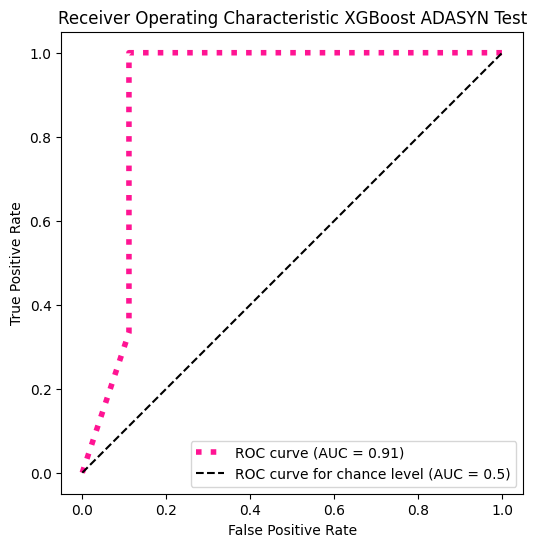

In [29]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from itertools import cycle
from sklearn.preprocessing import label_binarize
import numpy as np


y_pred_prob = xgb_adasyn.predict_proba(X_test)[:, 1]  # Use the probabilities for the positive class
n_classes = 2
target_names = ['none', 'VVR']

# Compute ROC curve and ROC area for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC score:\n{roc_auc:.2f}")

# Plot ROC curve
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(
    fpr,
    tpr,
    label=f"ROC curve (AUC = {roc_auc:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

# Plot the diagonal line representing chance level
plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic XGBoost ADASYN Test")
plt.legend()
plt.show()
